<a href="https://colab.research.google.com/github/swapnanilsharma/NLP-tasks-using-Deep-Learning/blob/master/Transfer_Learning_from_a_pretrained_model_from_Tensorflow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required libraries**

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import datetime
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

**Import dataset**

In [0]:
datasets, info = tfds.load(name='amazon_us_reviews/Major_Appliances_v1_00',
                           with_info=True,
                           split=('train[:70%]', 'train[70%:85%]', 'train[85%:]'))

In [16]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

Converting target variable to binary


In [0]:
@tf.function
def target(x):
  if x > 3:
    return 1
  else:
    return 0

In [20]:
for reviews in datasets[0].take(2):
  review_text = reviews['data']
  print(review_text.get('review_body').numpy())
  star_rating = review_text.get('star_rating')
  print(star_rating.numpy())
  print(target(star_rating).numpy())

b'Just was described, works great, fast shipping!!'
5
1
b'Amazing replacement! I kept buying the exspensive name brand filters and decided to try this out. You could not tell the difference! Awesome product!'
5
1


In [0]:
def fetch(tensor):
  text = tensor['data'].get('review_body')
  label = target(tensor['data'].get('star_rating'))
  return text, label

In [0]:
train_data_f = datasets[0].map(fetch)
test_data_f = datasets[1].map(fetch)
val_data_f = datasets[2].map(fetch)

In [0]:
train_data, train_labels = next(iter(train_data_f.batch(5)))

In [24]:
train_data[0], train_data[:1],  train_labels

(<tf.Tensor: shape=(), dtype=string, numpy=b'Just was described, works great, fast shipping!!'>,
 <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Just was described, works great, fast shipping!!'], dtype=object)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 0, 1, 0], dtype=int32)>)

In [0]:
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, output_shape=[128], trainable=True)
#hub_layer(train_data[:1])

In [28]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 124,646,849
Trainable params: 124,646,849
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [0]:
train_data_f = train_data_f.batch(512) #shuffle(70000).
val_data_f = val_data_f.batch(512)


In [31]:
history = model.fit(train_data_f, epochs=2, validation_data=val_data_f, verbose=1)

Epoch 1/2
133/133 [==============================] - 187s 1s/step - loss: 0.5485 - accuracy: 0.7905 - val_loss: 0.5046 - val_accuracy: 0.8782
Epoch 2/2
133/133 [==============================] - 182s 1s/step - loss: 0.4929 - accuracy: 0.8934 - val_loss: 0.4958 - val_accuracy: 0.8825


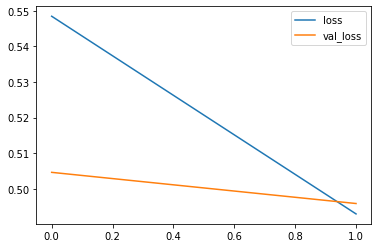

In [32]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [33]:
results = model.evaluate(test_data_f.batch(512), verbose=True)
print(results)

29/29 [==============================] - 6s 201ms/step - loss: 0.4965 - accuracy: 0.8825
[0.49650028347969055, 0.8824905157089233]


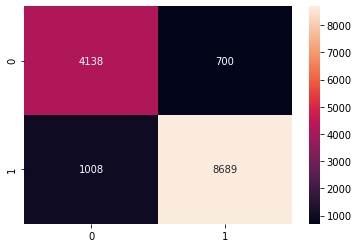

In [57]:
for f0, y_actual in test_data_f.batch(20000):
  y_pred=tf.where(model.predict(f0)>0.5, 1, 0)
  cf_matrix = confusion_matrix(y_actual, y_pred)
  sns.heatmap(cf_matrix, annot=True, fmt="d")
  plt.show()
  #print(tf.math.confusion_matrix(labels=y_actual, predictions=y_pred, num_classes=2))